<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Flag_of_France.svg/320px-Flag_of_France.svg.png">
</td>


# Analyse des sources de l'édition française du *Huff Post* (2012-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 25
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "France"
huff = huff[huff.pays == edition]
huff.shape

(54156, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

Le Huffington Post        53563
Le Monde.fr               201  
Le Figaro                 67   
leparisien.fr             44   
L'Obs                     38   
Le Point                  19   
LeJDD.fr                  15   
Libération.fr             14   
LExpress.fr               14   
Courrier international    13   
RTL.fr                    13   
Les Inrocks               11   
                          ..   
Plat du pied, sécurité    1    
L’instit’humeurs          1    
Droite(s) extrême(s)      1    
VoxEurop.eu               1    
Radio-Canada.ca           1    
Le Courrier Picard        1    
De quoi je me MEL         1    
Lindependant.fr           1    
Vanity Fair               1    
Le Figaro Bourse          1    
Rouges et verts           1    
Passeur de sciences       1    
Name: meta, Length: 84, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

Le Huffington Post     53563
The Huffington Post    8    
Le Huffingtonpost      1    
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(53572, 13)

In [7]:
len(huff) - len(huff[metaHP])

584

Le calcul ci-haut nous indique qu'on a **584 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? Le HuffPost                                                                         12756
? Le HuffPost avec AFP                                                                3529 
? AFP                                                                                 3189 
? Le HuffPost/AFP                                                                     3065 
? Rédaction du HuffPost                                                               2428 
Geoffroy Clavel Chef du service politique du HuffPost                                 2000 
Alexis Ferenczi                                                                       1976 
Alexandre Boudet Journaliste politique au HuffPost                                    1732 
? Rédaction du HuffPost avec AFP                                                      1555 
Lauren Provost Rédactrice en chef adjoint                                             1554 
? Rédaction Le HuffPost avec AFP                                                

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent à peine **0,5%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(253, 0.46716891941797772)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(37820, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(? Le HuffPost                                                                               12756
 ? Le HuffPost avec AFP                                                                      3529 
 ? Le HuffPost/AFP                                                                           3065 
 ? Rédaction du HuffPost                                                                     2428 
 Geoffroy Clavel Chef du service politique du HuffPost                                       2000 
 Alexandre Boudet Journaliste politique au HuffPost                                          1732 
 ? Rédaction du HuffPost avec AFP                                                            1555 
 ? Rédaction Le HuffPost avec AFP                                                            995  
 ? Rédaction Le HuffPost                                                                     908  
 Paul Guyonnet Paul Guyonnet est journaliste vidéo généraliste au Huffington Post France.    687  
 ? La réda

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **37&nbsp;820 articles** signés par **368 signataires différents**.<br>
Cela représente plus des deux tiers de l'ensemble des articles publiés par l'édition française du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(37820, 69.835290641849468)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(15752, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(? AFP                                                                                        3189
 Alexis Ferenczi                                                                              1976
 Lauren Provost Rédactrice en chef adjoint                                                    1554
 Sandra Lorenzo Journaliste responsable de la rubrique C'est La Vie                           846 
 Jean-Baptiste Duval                                                                          693 
 Jade Toussay Journaliste                                                                     562 
 Marine Le Breton Journaliste "C'est la vie"                                                  455 
 Romain Herreros Journaliste politique                                                        440 
 Nabil Touati                                                                                 420 
 Marine Chassagnon Journaliste culture                                                        396 
 Stanislas

Des 250 signataires ci-dessus, par contre, on trouve plusieurs «&nbsp;employés fantôme&nbsp;». Ils comprennent, dans leur signature, les mots «&nbsp;journaliste&nbsp;», «&nbsp;rédactrice&nbsp;», «&nbsp;editor&nbsp;» ou *«&nbsp;Brasil Post&nbsp;»*, par exemples.
On pourrait également considérer comme auteurs d'articles originaux les noms seuls.

Ainsi, on retranchera uniquement les signataires clairement identifiés à des agences externes. Il y en a 3&nbsp;757.

Cela signifie donc qu'il y a 11&nbsp;995 articles à ajouter à notre variable `HP_oui`.

In [15]:
HP_oui = huff[metaHP][signeHP].pays.count() + 11995
HP_oui, (HP_oui/len(huff))*100

(49815, 91.984267671172177)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, et additionner les articles qu'on a identifié plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*, puis retrancher tous les articles qu'on vient de ranger dans notre variable `HP_oui`.

In [16]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 11995
HP_non, (HP_non/len(huff))*100

(4088, 7.5485634094098533)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

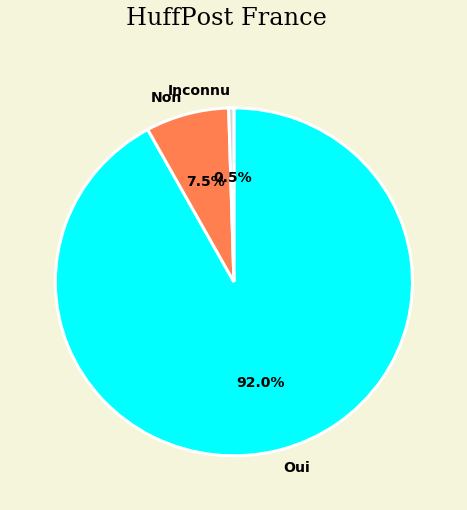

In [17]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost France", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [18]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

video                         10578
politique                     7515 
culture                       6033 
international                 5914 
insolite                      5821 
people                        4941 
vidéo                         3984 
sport                         3854 
le bon lien                   3438 
musique                       2892 
photos                        2677 
cinéma                        2548 
                              ...  
julian bugier jt              1    
avril lavigne chad kroeger    1    
manuela-carmena               1    
mode lady gaga                1    
To The Wonder                 1    
magic mike stripteases        1    
relations avec son patron     1    
xkeyscore                     1    
Munther Omar Saleh            1    
louvre paris                  1    
tuncay ceylan                 1    
village seyne-les-alpes       1    
Length: 96753, dtype: int64